# bertrand2025/figure2
Plot figure 2 from Bertrand et al. 2025, "Increasing wintertime cloud opacity increases surface longwave radiation at a long-term  Arctic observatory".

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

#from load_preproc_nb40 import load_arm_temp, load_abo_temp, nanmean, load_minutely_flux_hists
from prep_basecase_nb44 import *
from analyze_by_basecase_nb48 import *

from IPython.display import display, Math

In [2]:
declim = lambda ds: ds.groupby('time.month') - ds.groupby('time.month').mean()
#subset to DJFM
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))

# 2. base cases

## 2.1 load data

In [3]:
def get_config(which):
    if which == 'mixed':
        #segs_by_kind = {'liq':liq_segs_masked,'ice':ice_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'], 
            ['iwc','lwc'], 
            ['reice','reliq'] ]
        bounds_by_axis = [
            ['liq','liq'],
            ['ice','liq'],
            ['ice','liq'] ]
        ymax = 5e3 #3
    elif which == 'ice':
        #segs_by_kind = {'ice':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'], 
            ['iwc','_'], 
            ['reice','_'] ]
        bounds_by_axis = [
            ['ice','ice'],
            ['ice','_'],
            ['ice','_'] ]
        ymax = 5e3
    elif which == 'liquid':
        #segs_by_kind = {'liq':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'], 
            ['_','lwc'], 
            ['_','reliq'] ]
        bounds_by_axis = [
            ['liq','liq'],
            ['_','liq'],
            ['_','liq'] ]
        ymax = 5e3 #1.5
    #return segs_by_kind, varnames_by_axis, bounds_by_axis, ymax
    return varnames_by_axis, bounds_by_axis, ymax

## 2.2 plot

In [4]:
reduce_proc = lambda da: da.median(dim='time') #.mean(dim='time')

In [5]:
def post_norm(profile,wp,heights):
    '''scale water content profile to water path'''
    profile = profile-profile.min() #minimum value of 0
    profile = profile.rename(zk='height').assign_coords(height=heights) #change to physical height
    norm    = profile.fillna(0).integrate('height') #find normalization constant
    return wp/norm*profile

In [6]:
# load weights f
da_weights_djfm = xr.open_dataset('cloud_phase_monthly_frequency.nc')
da_weights_djfm = da_weights_djfm['weights']
da_weights_avg  = da_weights_djfm.mean('time')

In [7]:
# load base case specification datasets
spec_met = xr.open_dataset('46-1-base_cases_met.nc')
spec_cld = xr.open_dataset('46-1-base_cases_cld.nc')
spec = xr.merge([spec_met,spec_cld])
cloudy = xr.DataArray(data=[True,True,True,False],dims=['type'],
                      coords={'type':np.array(['liquid', 'mixed', 'ice','clear'])})
spec = spec.assign(is_cloudy=cloudy)

In [8]:
def get_rel_norms(spec,which):
    '''return window-averaged relative profiles and column-integrated microphysics

    Parameters:
    --------------
    spec            dataset specifying base case profiles for a set of types

    Returns:
    -------------
    rel_norms       dataset of layer-integrated or layer-averaged bulk microphysics
    '''
    data_vars = [ ]
    spec_i = spec.sel(type=which)
    if spec_i.height.attrs['units'] == 'km':
        spec_i = spec_i.copy()
        spec_i['height'] = spec_i['height']*1e3
    #calculate microphysics
    if which != 'ice':
        #relative LWP
        LWP     = spec_i.lwc.fillna(0).integrate('height') 
        #relative liquid effective radius
        reliq_avg   = spec_i.reliq.where(lambda da: da>0).mean('height') #um
        #save
        data_vars.append(LWP)
        data_vars.append(reliq_avg)
    if which != 'liquid':
        #relative IWP
        IWP     = spec_i.iwc.fillna(0).integrate('height') 
        #relative ice effective radius
        reice_avg   = spec_i.reice.where(lambda da: da>0).mean('height') #um
        #save
        data_vars.append(IWP)
        data_vars.append(reice_avg)
    return xr.merge(data_vars)

In [9]:
def get_cloud_bounds(spec,which):
    '''infer layer bounds from micro profiles. Only accurate to dz/2 of spec.'''
    usage_var = {'ice':['iwc'],'liquid':['lwc'],'mixed':['iwc','lwc']}
    kind_map  = {'iwc':'ice','lwc':'liq'}
    dz        = spec.height.diff('height').mean()
    bounds    = { }
    for cldvar in usage_var[which]:
        da = spec.sel(type=which)[cldvar]
        hts = da.height.sel(height=da.notnull())
        btm = hts.min()-dz/2
        top = hts.max()+dz/2
        bounds[kind_map[cldvar]] = [btm.item(),top.item()]
    return bounds

In [10]:
def get_config(which):
    if which == 'mixed':
        #segs_by_kind = {'liq':liq_segs_masked,'ice':ice_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'] ]
        bounds_by_axis = [
            ['liq','liq'] ]
        ymax = 5 #3
    elif which == 'ice':
        #segs_by_kind = {'ice':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'] ]
        bounds_by_axis = [
            ['ice','ice'] ]
        ymax = 5
    elif which == 'liquid':
        #segs_by_kind = {'liq':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'] ]
        bounds_by_axis = [
            ['liq','liq'] ]
        ymax = 5 #1.5
    #return segs_by_kind, varnames_by_axis, bounds_by_axis, ymax
    return varnames_by_axis, bounds_by_axis, ymax

In [11]:
rel_norm_shortnames = {
    'iwc': 'IWP',
    'lwc': 'LWP',
    'reliq': r'$\overline{r_{e,liq}}$',
    'reice': r'$\overline{r_{e,ice}}$'
}

rel_norm_units = {
    'iwc': 'g/m$^2$',
    'lwc': 'g/m$^2$',
    'reliq': '$\mathrm{\mu}$m',
    'reice': '$\mathrm{\mu}$m'
}

units = {'theta': 'K',
         'rh': '%',
         'iwc': 'g/m$^3$',
         'lwc': 'g/m$^3$',
         'reliq': '$\mathrm{\mu}$m',
         'reice': '$\mathrm{\mu}$m'}

long_names = {'theta': 'Potential temperature',
              'rh': 'Relative humidity',
              'iwc': 'Ice water content',
              'lwc': 'Liquid water content',
              'reliq': 'Liquid effective radius',
              'reice': 'Ice effective radius'}

long_type_names = {'mixed': 'Mixed-phase','ice':'Ice-only',
                   'liquid':'Liquid-only','clear':'Clear-sky'}

cloud_props = ['iwc','lwc','reice','reliq']

host_color, par_color = 'b', 'k'

# 3. all-time attribution results

## 3.1 downwelling longwave by driver

### 3.1.0 load and analyze data

In [12]:
def group_by_type(ds,masks):
        '''aggregate dataset to monthly means according to times in masks'''
        ds_by_type = [ ]
        for name,mask in masks.items():
            ds_sub = ds.sel(time=mask)
            ds_sub = ds_sub.resample(time='MS').mean()
            ds_sub = ds_sub.assign_coords(type=name)
            ds_sub.attrs = ds.attrs
            ds_by_type.append(ds_sub)
        ds_by_type = xr.concat(ds_by_type,dim='type')
        return ds_by_type

def get_split_iwp(thresh=70,add_type_dim=True): #g/m2
    '''recalculate monthly-mean ice water path<thresh g/m2 and ice water path>thresh g/m2 by base case'''
    #load cloud props
    folder = Path('~/Documents/arm_data').expanduser()
    fps = sorted(Path(folder/'ipynb_processed'/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
    ds = xr.open_mfdataset(fps)
    iwp   = ds.iwp.compute()
    phase = ds.phase.compute()
    is_phase = bit_packed_to_broad_categories(phase.astype(int))
    #align+restrict to DJFM
    iwp = iwp.where(iwp['time.month'].isin([12,1,2,3]),drop=True)
    is_phase = sub_mos(is_phase)
    #restrict LWP/IWP be consistent with phase mask
    iwp_masked  = iwp.where(is_phase.ice | is_phase.mixed)
    #split into thresholds
    iwphi_masked = iwp_masked.where(lambda da: da>=thresh)
    iwp_masked = iwp_masked.where(lambda da: da<thresh)
    if add_type_dim:
        #minutely to monthly by base case
        iwp_masked   = group_by_type(iwp_masked,is_phase)
        iwphi_masked = group_by_type(iwphi_masked,is_phase)
    return {'iwp':iwp_masked,'iwphi':iwphi_masked}

def get_split_lwp(thresh=50,add_type_dim=True): #g/m2
    '''recalculate monthly-mean liquid water path<thresh g/m2 and ice water path>thresh g/m2 by base case'''
    #load cloud props
    folder = Path('~/Documents/arm_data').expanduser()
    fps = sorted(Path(folder/'ipynb_processed'/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
    ds = xr.open_mfdataset(fps)
    lwp   = ds.lwp.compute()
    phase = ds.phase.compute()
    is_phase = bit_packed_to_broad_categories(phase.astype(int))
    #align+restrict to DJFM
    lwp = lwp.where(lwp['time.month'].isin([12,1,2,3]),drop=True)
    is_phase = sub_mos(is_phase)
    #restrict LWP/IWP be consistent with phase mask
    lwp_masked  = lwp.where(is_phase.liquid | is_phase.mixed)
    #split into thresholds
    lwphi_masked = lwp_masked.where(lambda da: da>=thresh)
    lwp_masked = lwp_masked.where(lambda da: da<thresh)
    if add_type_dim:
        #minutely to monthly by base case
        lwp_masked   = group_by_type(lwp_masked,is_phase)
        lwphi_masked = group_by_type(lwphi_masked,is_phase)
    return {'lwp':lwp_masked,'lwphi':lwphi_masked}

In [13]:
def nosum_extensive(dfj_dt,fj,yj):
    '''
    total change in linear combination response variable due to changing weights
    if y = sum_j f_j*y_j, the change in y implied by changing f_j
    
    dfj_dt: slopes of response frequency 'f' to predictor 't' by case 'j'
    fj:     frequencies by cases by case 'j'
    yj:     values of response 'y' by case 'j' 
    '''
    y        = (yj*fj).sum('type')         #value of y (weighted average of yj)
    dy_dfj   = yj - (y-fj*yj)/(1-fj)       #change in y due to change in fj
    dydt_ext = (dy_dfj*dfj_dt)             #change in y due to t via changing fj
    return dydt_ext

In [14]:
def product_uncertainty(out_mean,ins_mean,ins_err):
    '''uncertainty propagation for products/quotients'''
    terms   = [(x_err/x_mean)**2 for x_mean,x_err in zip(ins_mean,ins_err)]
    rel_err = np.sqrt(sum(terms))
    return out_mean*rel_err

#product_uncertainty(dFdf_med*dfdt_med,[dFdf_med,dfdt_med],[dFdf_err,dfdt_err])
#attrib_ext_err = ([dFdf_med*dfdt_med])**2).sum('type')

In [15]:
def symmetrize_error(ds,dim='case',alpha=0.05):
    med = ds.median(dim)
    dlo = np.abs(med-ds.quantile(alpha,dim=dim))
    dhi = np.abs(ds.quantile(1-alpha,dim=dim)-med)
    err = xr.where(dlo<dhi,dlo,dhi)
    return err

In [16]:
attributed_err_by_case = xr.open_dataset('drivers_by_type_error.nc')
attributed_med_by_case = xr.open_dataset('drivers_by_type.nc')
attrib_tot_med = xr.open_dataset('allsky_attributed_driving.nc')
attrib_tot_err = xr.open_dataset('allsky_attributed_driving_error.nc')

### 3.1.1 plot by sum (simple)

In [17]:
long_names = {
    'tot_cld': 'Cloud cover',
    'liq_cld': 'Cloud phase',
    'lwp': 'Liquid water path',
    'pwv': 'Water vapor',
    'pwv_cc': r'PWV$_\mathrm{CC}$',
    'Temp_Air': 'Air temperature',
    'temp': r'$T_{2m}$',
    'planck': 'Planck',
    'column_air_temperature': r'Lapse rate',
    'cbh': r'Cloud altitude',
    'twp': r'Cloud water path',
    'iwp': 'Ice water path',
    'iwphi': 'Opaque ice water path',
    'cloud_liquid': r'$f_{liq}$',
    'cloud_mixed': r'$f_{mix}$',
    'cloud_ice': r'$f_{ice}$',
    'co2': r'Direct CO$_2$',
    'lwu': r'$F_U$',
    'lwd': r'$F_D$',
    'lwn': r'$F_N$',
    'total':'Total'
}

## 3.3 Base case summary and LWD attribution by base case

In [18]:
if spec['height'].attrs['units'] == 'm':
    spec['height'] = spec['height']/1e3
    spec['height'].attrs['units'] = 'km'

In [19]:
labels = attributed_med_by_case.feature
labels = [long_names[key] for key in labels.data]

In [20]:
da_med = attrib_tot_med.to_array()
da_hi  = attrib_tot_med.to_array()+attrib_tot_err.to_array()
da_lo  = attrib_tot_med.to_array()-attrib_tot_err.to_array()

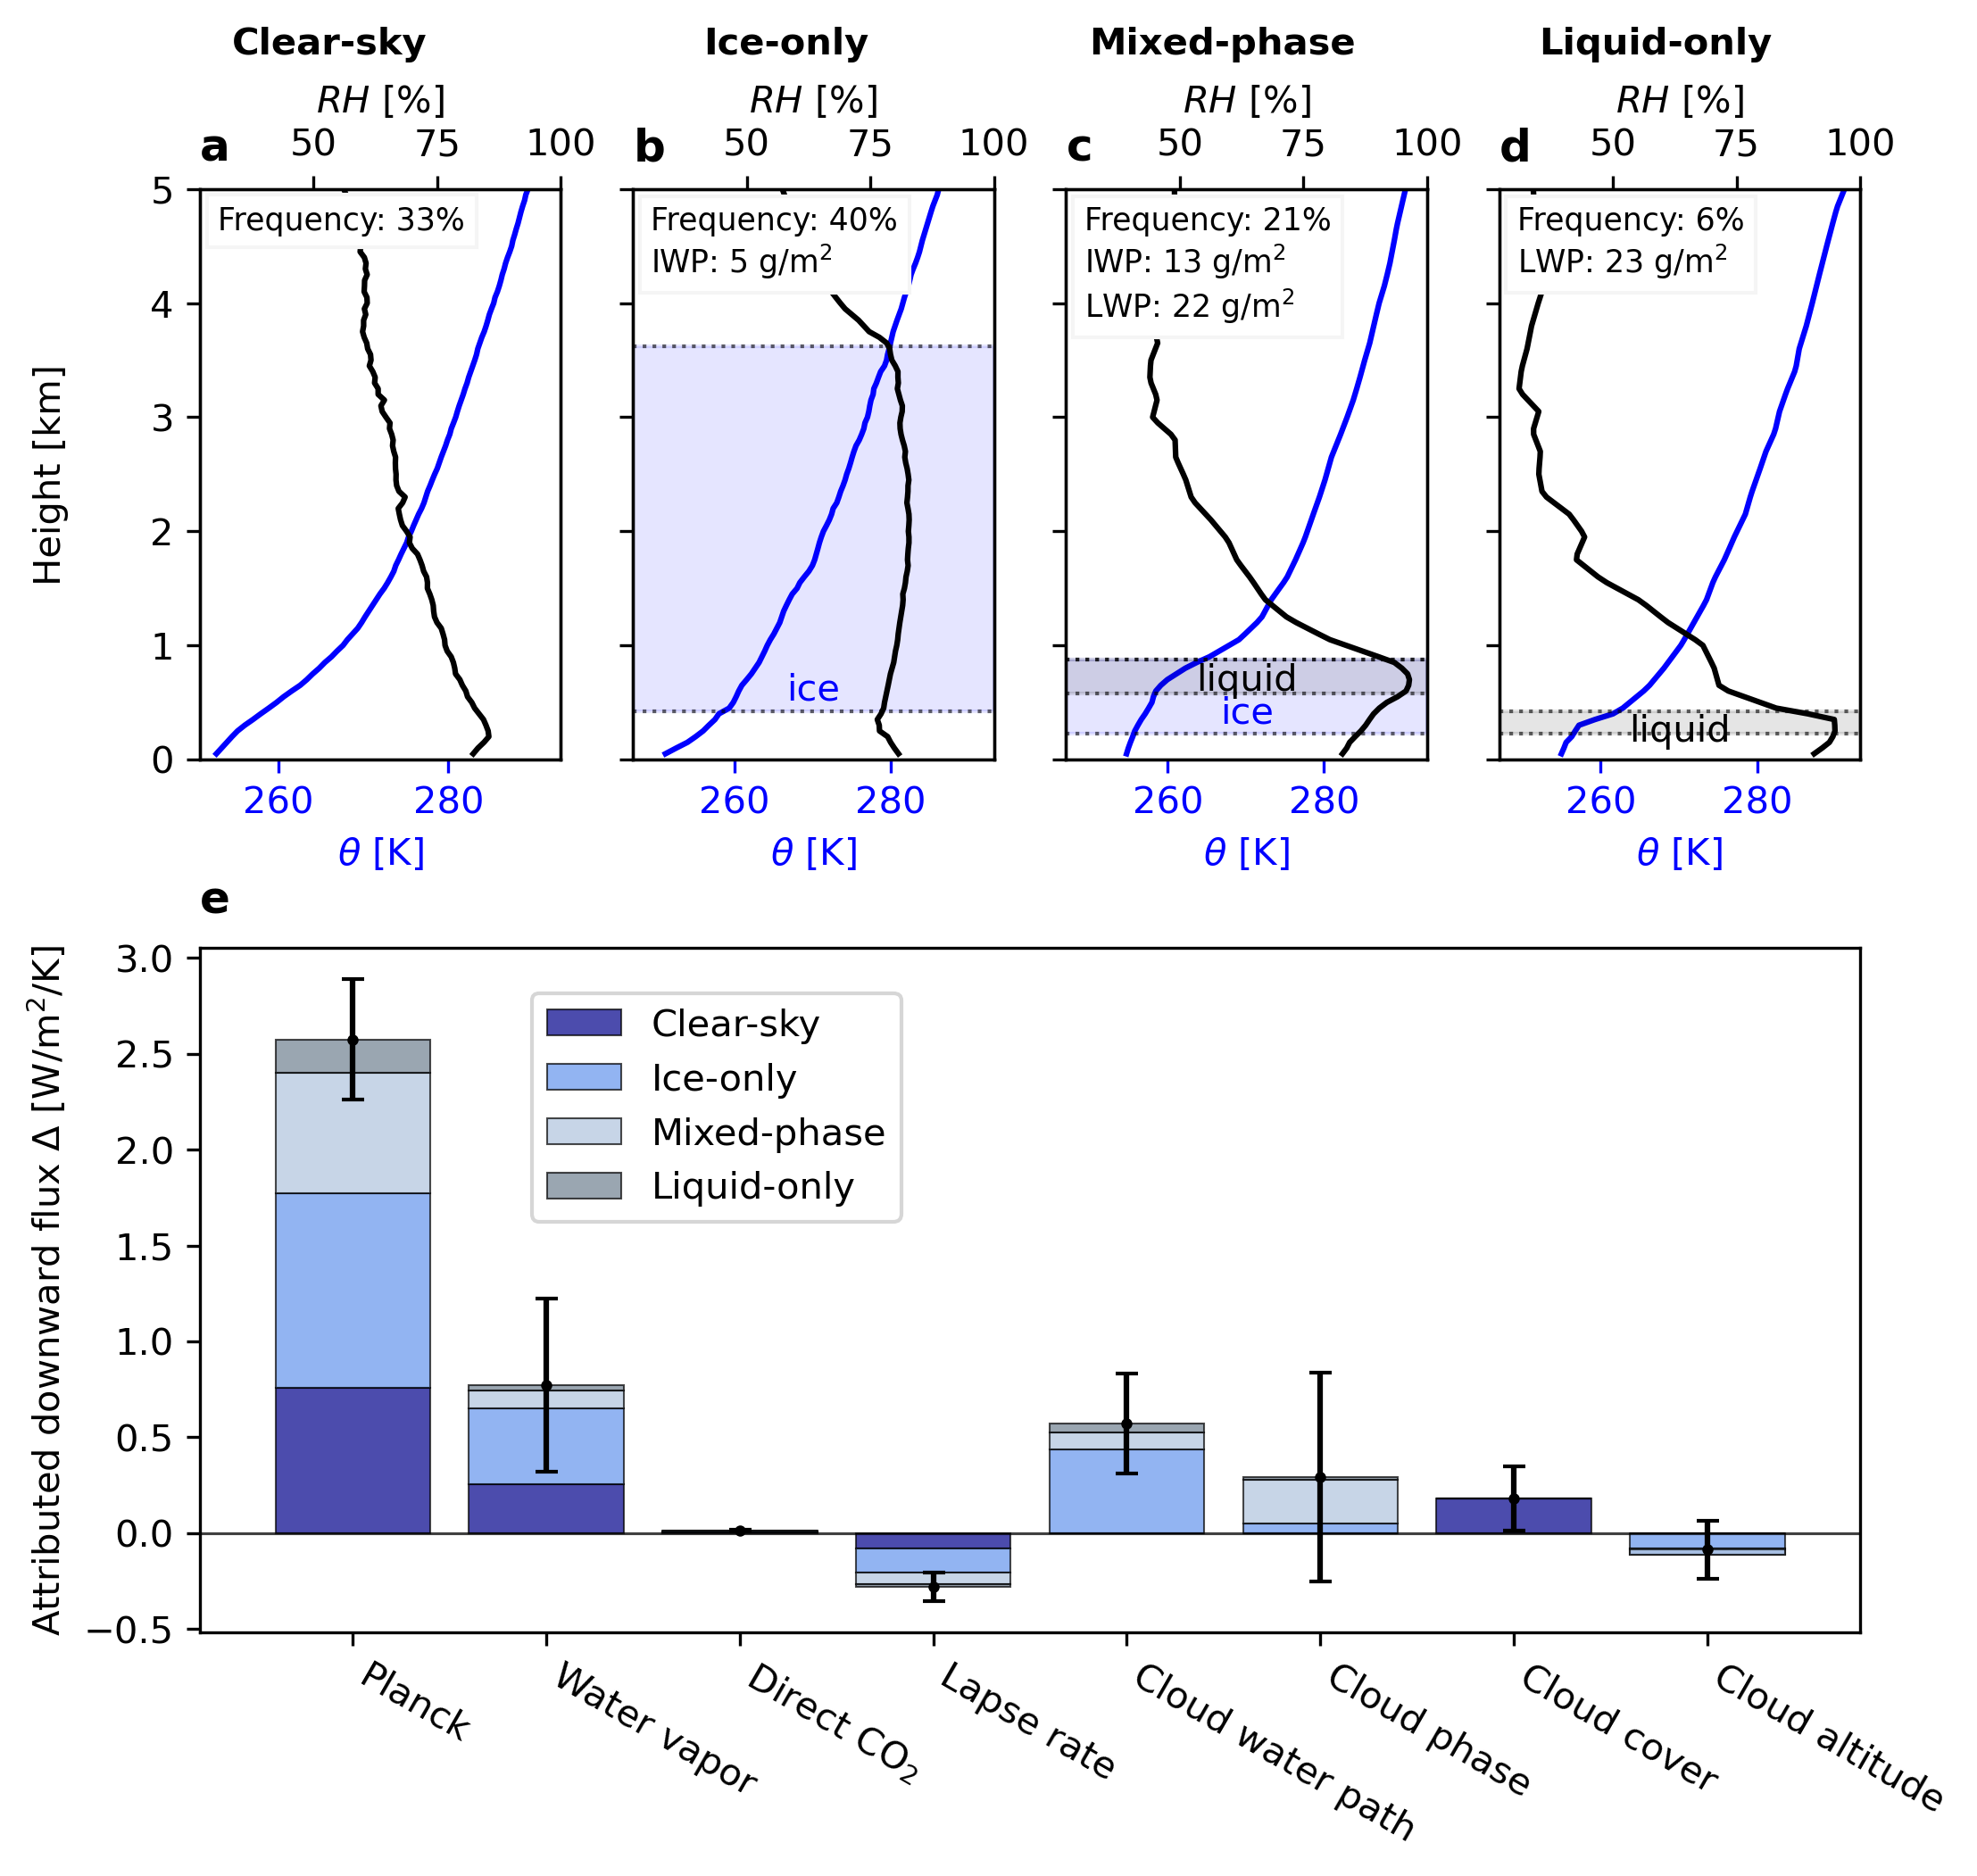

In [21]:
fig,axes = plt.subplots(2,4,dpi=300,figsize=(8,7),sharey='row',height_ratios=[1,1.2])
text_pos = iter([0.14,0.36,0.54,0.75]) #row labels

#turn second row into one long axis
gs = axes[0, 0].get_gridspec()
# remove the underlying Axes
for ax in axes[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])

#################################
##### BASE CASE METEOROLOGY #####
#################################

rel_norm_shortnames = {
    'iwc': 'IWP',
    'lwc': 'LWP',
    'reliq': r'$\overline{r_{e,liq}}$',
    'reice': r'$\overline{r_{e,ice}}$'
}

rel_norm_units = {
    'iwc': 'g/m$^2$',
    'lwc': 'g/m$^2$',
    'reliq': '$\mathrm{\mu}$m',
    'reice': '$\mathrm{\mu}$m'
}

units = {'theta': 'K',
         'rh': '%',
         'iwc': 'g/m$^3$',
         'lwc': 'g/m$^3$',
         'reliq': '$\mathrm{\mu}$m',
         'reice': '$\mathrm{\mu}$m'}

long_names = {'theta': r'$\theta$',
              'rh': r'$RH$',
              'iwc': 'Ice water content',
              'lwc': 'Liquid water content',
              'reliq': 'Liquid effective radius',
              'reice': 'Ice effective radius'}

long_type_names = {'mixed': 'Mixed-phase','ice':'Ice-only','liquid':'Liquid-only','clear':'Clear-sky'}

cloud_props = ['iwc','lwc','reice','reliq']

host_color, par_color = 'b', 'k'

### CLEAR-SKY MET ###
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))

clear = spec.sel(type='clear')
ymax=5
ax = axes[0,0]
par = ax.twiny()
for color,xaxis,data_var in zip([host_color,par_color],[ax,par],['theta','rh']):
    #get average profile
    #plot
    p, = xaxis.plot(clear[data_var].where(clear.height.data<=ymax*1.1),clear.height,c=color)
    xaxis.set_xlabel(f'{long_names[data_var]} [{units[data_var]}]')
    xaxis.xaxis.label.set_color(p.get_color())
    xaxis.tick_params(axis='x', colors=p.get_color())
ax.set_ylim(0,ymax)
par.set_xlim([27,100])

text_x = next(text_pos)
dy=0.058
which_name = f"Clear-sky"
fig.text(text_x, 1.01-dy,
     which_name, 
     weight = 'bold',
     fontsize = 'medium',
     rotation = 'horizontal',
     ha = 'left')
par.text(0.05,0.97,
         f"Frequency: {da_weights_avg.sel(type='clear').mean():.0%}",
         fontsize = 'smaller',
         #weight = 'ultralight',
         rotation = 'horizontal',
         ha = 'left',
         va = 'top',
         transform = ax.transAxes,
         zorder=1000,
         bbox = dict(facecolor='white', edgecolor='whitesmoke',alpha=1.0, pad=3, zorder=1000))


### CLOUDY MET ###
print_props = {'ice':['iwc'],'mixed':['iwc','lwc'],'liquid':['lwc']}
for which,ax in zip(['ice','mixed','liquid'],axes[0,1:]):
    #get plot options corresponding to base case
    varnames_by_axis, bounds_by_axis, ymax = get_config(which)
    data_vars = varnames_by_axis[0]
    kinds = bounds_by_axis[0]

    #plot profiles
    dz=0
    par = ax.twiny()
    for color,xaxis,kind,data_var in zip([host_color,par_color],[ax,par],kinds,data_vars):
        if kind == '_':
            xaxis.get_xaxis().set_ticks([])
            continue
        #get average profile
        heights = spec.height
        profile = spec[data_var].sel(type=which)
        rel_norms = get_rel_norms(spec,which)
        #plot
        p, = xaxis.plot(profile.where(heights.data<=ymax*1.1),heights,c=color,zorder=-100)
        xaxis.set_xlabel(f'{long_names[data_var]} [{units[data_var]}]')
        xaxis.xaxis.label.set_color(p.get_color())
        xaxis.tick_params(axis='x', colors=p.get_color())
        ax.set_xlim([247, 293.2])
        par.set_xlim([27,100])
    
    #add cloud bounds
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    colors = {'liq':par_color,'ice':host_color}
    bounds = get_cloud_bounds(spec,which)
    for kind,[base,top] in bounds.items():
        # layer_bases = segs.base_heights.median('time')
        # base, top = layer_bases.sel(layer=1), layer_bases.sel(layer=2)
        ax.axhline(top,c=color,alpha=0.6,lw=1,ls=':')
        ax.axhline(base,c=color,alpha=0.6,lw=1,ls=':')
        ax.fill_between([x0,x1],[base,base],[top,top],color=colors[kind],alpha=0.1)
        #ax.text(1.05*(x1-x0)+x0,base,f'{kind} base',c=color,rotation='vertical',va='center')
        yloc = top-0.005*(y1-y0) if kind=='liq' else base+0.005*(y1-y0)
        ax.text(0.5*(x1-x0)+x0,yloc,
                'liquid' if kind=='liq' else kind, ha='center',
                rotation='horizontal',c=colors[kind],va='top' if kind=='liq' else 'bottom')
    ax.set_xlim([x0,x1])
    ax.set_ylim([y0,y1])

    #add row label
    N = spec.sel(type=which).accepted_counts.data
    text_x = next(text_pos)
    fig.text(text_x, 1.01-dy,
         f'{long_type_names[which]}',
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'horizontal',
         ha = 'left')

    #print summary info
    text_avg=f'Frequency: {da_weights_avg.sel(type=which):.0%}\n'
    for sub_data_var in print_props[which]:
        #stats
        rel_norms = get_rel_norms(spec,which)
        text_avg += f'{rel_norm_shortnames[sub_data_var]}: {rel_norms[sub_data_var]:.0f} {rel_norm_units[sub_data_var]}\n'
    par.text(0.05,0.97,
         text_avg[:-1], 
         fontsize = 'smaller',
         #weight = 'ultralight',
         rotation = 'horizontal',
         ha = 'left',
         va = 'top',
         transform = ax.transAxes,
         zorder=1000,
         bbox = dict(facecolor='white', edgecolor='whitesmoke',alpha=1.0, pad=3, zorder=1000))

axes[0][0].set_ylim(0,5)
axes[0,0].set_ylabel("Height [km]")
fig.subplots_adjust(hspace=0.3)

###########################
##### LWD ATTRIBUTION #####
###########################
long_names = {
    'tot_cld': 'Cloud cover',
    'liq_cld': 'Cloud phase',
    'lwp': 'Liquid water path',
    'pwv': 'Water vapor',
    'pwv_cc': r'PWV$_\mathrm{CC}$',
    'Temp_Air': 'Air temperature',
    'temp': r'$T_{2m}$',
    'planck': 'Planck',
    'column_air_temperature': r'Lapse rate',
    'cbh': r'Cloud altitude',
    'twp': r'Cloud water path',
    'iwp': 'Ice water path',
    'iwphi': 'Opaque ice water path',
    'lwphi': 'Opaque liquid water path',
    'cloud_liquid': r'$f_{liq}$',
    'cloud_mixed': r'$f_{mix}$',
    'cloud_ice': r'$f_{ice}$',
    'co2': r'Direct CO$_2$',
    'lwu': r'$F_U$',
    'lwd': r'$F_D$',
    'lwn': r'$F_N$',
    'total':'Total'
}

labels = attributed_med_by_case.feature
labels = [long_names[key] for key in labels.data]

ax = axbig
bottom = np.zeros(len(labels))
bar_kws      = {'alpha':0.7,'edgecolor':'k','linewidth':0.5}
colors=iter(['darkblue','cornflowerblue','lightsteelblue','slategray'])
for case_name, drivers_in_case in attributed_med_by_case.items():
    weights = da_weights_avg.sel(type=case_name).broadcast_like(drivers_in_case)
    weights = weights.where(lambda da: ~da.feature.isin(['tot_cld','liq_cld']),other=1)
    alltime_component = (drivers_in_case*weights).fillna(0)
    p = ax.bar(labels, alltime_component, label=long_type_names[case_name], bottom=bottom,color=next(colors),**bar_kws)
    bottom += alltime_component

ax.legend(loc=(0.2,0.6))

#bar
#labels = [long_names[key] for key in da_med.coords['variable'].data]
#ax.bar(labels,csum_med,bottom=0,color=colors,**bar_kws)

#convert plot data to array
da_med = attrib_tot_med.to_array()
da_hi  = attrib_tot_med.to_array()+attrib_tot_err.to_array()
da_lo  = attrib_tot_med.to_array()-attrib_tot_err.to_array()

#bar
labels = [long_names[key] for key in da_med.coords['variable'].data]
#ax.bar(labels,da_med,color=colors,**bar_kws)
#errorbar
yerr = [np.abs(da_hi-da_med), np.abs(da_med-da_lo)]
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
ax.errorbar(labels,da_med,yerr=yerr,**errorbar_kws)

ax.set_ylabel(r'Attributed downward flux $\Delta$ [W/m$^2$/K]')
if ax.get_ylim()[0]<=0.0:
    ax.axhline(0,c='k',lw=0.75,alpha=0.75)
#axes[0][0].set_ylim(-1,6.5)
#fig.suptitle('Attributable downwelling longwave response by base case ($\partial F_D/ \partial x_i$)')
for label in ax.get_xticklabels():
    label.set_ha("left")
    label.set_rotation(-30)
#fig.tight_layout()
#fig.savefig('55_longwave_down_total_response_by_case.pdf',bbox_inches='tight')

#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes[0]:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
axbig.text(0.0,1.05,next(letter),weight='bold',size='large',transform=axbig.transAxes)
fig.align_ylabels()
#fig.savefig('67-2-fig02_bertrand2025_R2R_tweaks.pdf',bbox_inches='tight',transparent=False)

### 3.3.1 get numbers that go in the figure write-up

In [22]:
dlwd_dT_noncld     = attrib_tot_med.drop(['tot_cld','twp','cbh','liq_cld']).to_array().sum()
dlwd_dT_noncld_err = np.sqrt((attrib_tot_err.drop(['tot_cld','twp','cbh','liq_cld']).to_array()**2).sum())
dlwd_dT_cld        = attrib_tot_med.drop(['planck','pwv','co2','column_air_temperature']).to_array().sum()
dlwd_dT_cld_err    = np.sqrt((attrib_tot_err.drop(['planck','pwv','co2','column_air_temperature']).to_array()**2).sum())
dlwd_dT_tot        = attrib_tot_med.to_array().sum()
dlwd_dT_tot_err    = np.sqrt(attrib_tot_err.to_array()**2).sum()
from IPython.display import display, Math, Markdown

display(Markdown('### All-sky driver sums'))
display(Math(r'$\partial_T F_D$ non-cloud only: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_noncld.data.item(0),dlwd_dT_noncld_err.data.item(0))))
display(Math(r'$\partial_T F_D$ cloud only: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_cld.data.item(0),dlwd_dT_cld_err.data.item(0))))
display(Math(r'$\partial_T F_D$ total: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_tot.data.item(0),dlwd_dT_tot_err.data.item(0))))

### All-sky driver sums

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
attrib_tot_med_opac = attrib_tot_med['twp']+attrib_tot_med['liq_cld']
attrib_tot_err_opac = np.sqrt((attrib_tot_err['twp']**2)+(attrib_tot_err['liq_cld']**2))
attrib_tot_med_temp = attrib_tot_med['planck']+attrib_tot_med['column_air_temperature']
attrib_tot_err_temp = np.sqrt((attrib_tot_err['planck']**2)+(attrib_tot_err['column_air_temperature']**2))
attrib_totcase_med_twp = da_weights_avg*attributed_med_by_case.sel(feature='twp').to_array('type')
attrib_totcase_err_twp = da_weights_avg*attributed_err_by_case.sel(feature='twp').to_array('type')
attrib_tot_med_opac_liq = attrib_tot_med['liq_cld']+attrib_totcase_med_twp.sel(type=['liquid','mixed']).sum('type')
attrib_tot_err_twp_liq  = np.sqrt((attrib_totcase_err_twp.sel(type=['liquid','mixed'])**2).sum('type'))
attrib_tot_err_opac_liq = np.sqrt((attrib_tot_err['liq_cld']**2)+attrib_tot_err_twp_liq**2)


display(Markdown('### Driver quantities stated in text'))
display(Math(r'$\partial_T F_D$'+' cloud phase: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['liq_cld'].data.item(0),attrib_tot_err['liq_cld'].data.item(0))))
display(Math(r'$\partial_T F_D$'+' cloud water path: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['twp'].data.item(0),attrib_tot_err['twp'].data.item(0))))
display(Math(r'$\partial_T F_D$'+' ice-only water path (all-sky): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_totcase_med_twp.sel(type='ice').data.item(0),attrib_totcase_err_twp.sel(type='ice').data.item(0))))
display(Math(r'$\partial_T F_D$'+' liquid-containing water path (all-sky): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_totcase_med_twp.sel(type=['liquid','mixed']).sum('type').data.item(0),np.sqrt((attrib_totcase_err_twp.sel(type=['liquid','mixed'])**2).sum('type')).data.item(0))))
display(Math(r'$\partial_T F_D$'+' liquid-containing opacity (twp+phase) (all-sky): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med_opac_liq.data.item(0),attrib_tot_err_opac_liq.data.item(0))))


display(Markdown('### Other quantities'))
display(Math(r'$\partial_T F_D$'+' opacity (twp+phase): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med_opac.data.item(0),attrib_tot_err_opac.data.item(0))))
display(Math(r'$\partial_T F_D$'+' warming (planck+LR): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med_temp.data.item(0),attrib_tot_err_temp.data.item(0))))
display(Math(r'$\partial_T F_D$'+' cloud cover: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['tot_cld'].data.item(0),attrib_tot_err['tot_cld'].data.item(0))))
display(Math(r'$\partial_T F_D$'+' water vapor: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['pwv'].data.item(0),attrib_tot_err['pwv'].data.item(0))))

### Driver quantities stated in text

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Other quantities

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>